In [80]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from py_vollib import black_scholes_merton as bsm

# Black Scholes Formula
$
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0
$

In [81]:
mm = 10
nn = 10

tt = np.arange(10)

print(np.arange(10))

for i in tt:
    # print(i)
    # print(i+1)
    pass

grid = np.zeros(shape=(mm+1, nn+1))

profit = 49.33 * np.exp(-0.1 * (1 - 0.01))
print(profit)
profit = 49.33 * np.exp(-0.1 * (1 - 0.99))
print(profit)
profit = 50 * np.exp(-0.1 * 0.0001)
print(profit)

[0 1 2 3 4 5 6 7 8 9]
44.68028778680165
49.28069465678039
49.99950000249999


# Finite Difference Class
## Discretization
- S is discretized by N Steps, $\Delta s = S_{max}/N$, then it can be splited as $\{s_0, s_1, s_2, \ldots, s_M\}$ or $\{0\Delta s, 1\Delta s, 2\Delta s, \ldots, (M-1)\Delta s, M\Delta s\}$
- T is discretized by M Steps, $\Delta t = T/M$, then it can be splited as $\{t_0, t_1, t_2, \ldots, t_M\}$ or $\{0\Delta t, 1\Delta t, 2\Delta t, \ldots, (N-1)\Delta t, N\Delta t\}$
- Using i to represent each space(price) step, $\{i_0, i_1, i_2, \ldots, j_{M-1}, i_M\}$
- Using j to represent each time step: $\{j_0, j_1, j_2, \ldots, j_{N-1}, j_N\}$

In [82]:
class FiniteDifferences(object):

    def __init__(self, S0, K, r, T, sigma, Smax, M, N,
                 is_call=True):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M, self.N = int(M), int(N)  # Ensure M&N are integers
        self.is_call = is_call
        
        # calculate the discretization size of the space(price) and time
        self.dS = Smax / float(self.M)
        self.dt = T / float(self.N)
        
        # create index list
        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        
        # save all the option price at each step into a 2-D matrix
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        
        # manipulate the asset price when the discretize step
        self.boundary_conds = np.linspace(0, Smax, self.M+1)

    def _setup_boundary_conditions_(self):
        pass

    def _setup_coefficients_(self):
        pass

    def _traverse_grid_(self):
        """  Iterate the grid forward in time """
        pass

    def _interpolate_(self):
        """
        Use piecewise linear interpolation on the initial
        grid column to get the closest price at S0.
        """
        return np.interp(self.S0, 
                         self.boundary_conds,
                         self.grid[:, -1])
        # return np.interp(self.S0, 
        #                  self.boundary_conds,
        #                  self.grid[:, 0])
        
    def price(self):
        self._setup_boundary_conditions_()
        self._setup_coefficients_()
        self._traverse_grid_()
        return self._interpolate_()
    
    def print_grid(self):
        possible_prices = {}
        for j in self.j_values:
            tmp  = []
            for i in range(self.M):
                tmp.append(self.grid[i, j])
                pass
            possible_prices[j] = tmp
        return possible_prices
    
    def get_info(self):
        infos = {}
        for j in self.j_values:
            tmp  = []
            for i in range(self.M)[:]:
                info = {'asset': i*self.dS, 'time': j*self.dt, 'option': self.grid[i, j]}
                tmp.append(info)
                pass
            infos[j] = tmp
        return infos

# The Explicit Method
## Difference approximation method
- Forward Difference approximation with respect to t.
- First-order Central Difference approximation with respect to S.
- Second-Order Symmetric Central Difference approximation with respect to S.
- To avoid instability issues, we need to set a reasonable intervals of time t, where 
            $0 < \Delta t < \frac{1}{\sigma^2(M-1) + \frac{1}{2}r}$.

In [83]:
""" Explicit method of Finite Differences using forward differenciation for time """
class FDExplicitEu(FiniteDifferences):

    def _setup_boundary_conditions_(self):
        if self.is_call:
            # Initial condition: At the end of the option contract, the price of the option should be equal to 
            self.grid[:, 0] = np.maximum(self.boundary_conds - self.K, 0)
            
            # Boundary condition: Terminal when the asset price hit the max value
            self.grid[-1, 1:] = (self.Smax - self.K) * np.exp(-self.r *
                                                               self.dt *
                                                               (self.N - self.j_values))
        else:
            # Initial condition: 
            self.grid[:, 0] = np.maximum(self.K - self.boundary_conds, 0)
            
            # Boundary condition: Terminal when the asset price hit the max value
            self.grid[0, 1:] = (self.K - self.Smax) * np.exp(-self.r * 
                                                              self.dt * 
                                                              (self.N - self.j_values))

    def _setup_coefficients_(self):
        self.a = 0.5 * self.dt * ((self.sigma**2) *
                                  (self.i_values**2) - 
                                  self.r * self.i_values)
        self.b = 1 - self.dt * ((self.sigma**2) * 
                                (self.i_values**2) + 
                                self.r)
        self.c = 0.5 * self.dt * ((self.sigma**2) * 
                                  (self.i_values**2) + 
                                  self.r*self.i_values)

    def _traverse_grid_(self):
        for j in self.j_values[:]:
            for i in range(self.M)[:]:
                self.grid[i, j+1] = self.a[i] * self.grid[i-1, j] + self.b[i] * self.grid[i, j] + self.c[i] * self.grid[i+1, j] 

# Call option

In [92]:
option = FDExplicitEu(S0=50, K=50, r =0.1, T=1.0, sigma = 0.4, Smax=100, M=200, N=10000, is_call=True)
print(option.price())

test_price = (bsm.black_scholes_merton(flag = 'c', S = 50, K = 50, q = 0, t = 1.0, r = 0.1, sigma = 0.4))
print(test_price)

prices = option.print_grid()
# print(len(prices))

# print(option.boundary_conds)
print(option.grid[-1, :-1])

info = option.get_info()
print(len(info))
print(info[100][-1])
print(info[5000][-1])
print(info[9999][-1])
print(info[9999][1])
print(info[9999][0])

9.749043131480262
10.159234655029346
[50.         45.2418709  45.24232332 ... 49.99800004 49.99850002
 49.99900001]
10000
{'asset': 99.5, 'time': 0.01, 'option': 45.26072792025366}
{'asset': 99.5, 'time': 0.5, 'option': 47.13367015110254}
{'asset': 99.5, 'time': 0.9999, 'option': 49.55952949849246}
{'asset': 0.5, 'time': 0.9999, 'option': 2.241783173366188e-19}
{'asset': 0.0, 'time': 0.9999, 'option': 0.0}


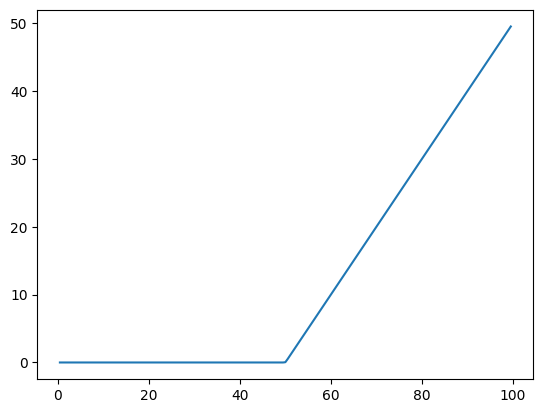

{'asset': 50.0, 'time': 0.0001, 'option': 0.04025000000000001}
{'asset': 49.5, 'time': 0.0001, 'option': 0.0}
{'asset': 99.5, 'time': 0.0001, 'option': 49.5005}
49.0
49.5005
49.5
50.0
-----------------------------------------
49.000499999999995
47.988693391704096
49.5005
45.241870901797974
-----------------------------------------
49.120438292892494
49.55903076284555
49.55952949849246
49.99900000999993
-----------------------------------------
49.12093580600466
49.55952949849246
49.56002823925194
49.99950000249999
[{'asset': 0.0, 'time': 0.0001, 'option': 0.0}, {'asset': 0.5, 'time': 0.0001, 'option': 0.0}, {'asset': 1.0, 'time': 0.0001, 'option': 0.0}, {'asset': 1.5, 'time': 0.0001, 'option': 0.0}, {'asset': 2.0, 'time': 0.0001, 'option': 0.0}, {'asset': 2.5, 'time': 0.0001, 'option': 0.0}, {'asset': 3.0, 'time': 0.0001, 'option': 0.0}, {'asset': 3.5, 'time': 0.0001, 'option': 0.0}, {'asset': 4.0, 'time': 0.0001, 'option': 0.0}, {'asset': 4.5, 'time': 0.0001, 'option': 0.0}, {'asset':

In [95]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info[1][i+1]['asset'])
    option_price.append(info[1][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info[1][100])
print(info[1][99])
print(info[1][-1])

print(option.grid[198, 0])
print(option.grid[199, 1])
print(option.grid[199, 0])
print(option.grid[200, 0])

print('-----------------------------------------')
print(option.grid[198, 1])
print(option.grid[199, 2])
print(option.grid[199, 1])
print(option.grid[200, 1])
print('-----------------------------------------')
print(option.grid[198, -2])
print(option.grid[199, -3])
print(option.grid[199, -2])
print(option.grid[200, -2])
print('-----------------------------------------')
print(option.grid[198, -1])
print(option.grid[199, -2])
print(option.grid[199, -1])
print(option.grid[200, -1])

print(info[1])

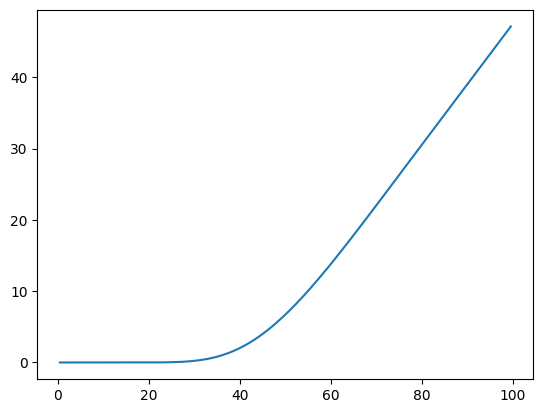

{'asset': 5.0, 'time': 0.5, 'option': 7.840481712477196e-15}
[{'asset': 0.0, 'time': 0.5, 'option': 0.0}, {'asset': 0.5, 'time': 0.5, 'option': 9.043497440146403e-30}, {'asset': 1.0, 'time': 0.5, 'option': 5.67523240744512e-27}, {'asset': 1.5, 'time': 0.5, 'option': 1.0692679236530952e-24}, {'asset': 2.0, 'time': 0.5, 'option': 9.46141650849697e-23}, {'asset': 2.5, 'time': 0.5, 'option': 4.803437268004298e-21}, {'asset': 3.0, 'time': 0.5, 'option': 1.5713564466976264e-19}, {'asset': 3.5, 'time': 0.5, 'option': 3.576904501881119e-18}, {'asset': 4.0, 'time': 0.5, 'option': 5.988312215292753e-17}, {'asset': 4.5, 'time': 0.5, 'option': 7.691975140974707e-16}, {'asset': 5.0, 'time': 0.5, 'option': 7.840481712477196e-15}, {'asset': 5.5, 'time': 0.5, 'option': 6.519933960209688e-14}, {'asset': 6.0, 'time': 0.5, 'option': 4.527351303042406e-13}, {'asset': 6.5, 'time': 0.5, 'option': 2.6777982291169384e-12}, {'asset': 7.0, 'time': 0.5, 'option': 1.3724744691339559e-11}, {'asset': 7.5, 'time': 0

In [86]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info[5000][i+1]['asset'])
    option_price.append(info[5000][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info[5000][10])
print(info[5000])

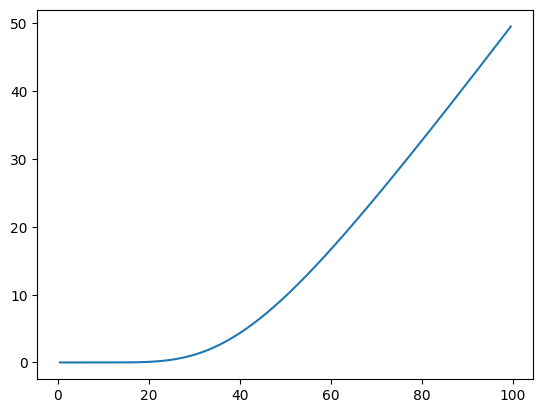

[{'asset': 0.0, 'time': 0.9999, 'option': 0.0}, {'asset': 0.5, 'time': 0.9999, 'option': 2.241783173366188e-19}, {'asset': 1.0, 'time': 0.9999, 'option': 5.045586970449686e-17}, {'asset': 1.5, 'time': 0.9999, 'option': 3.391291448949409e-15}, {'asset': 2.0, 'time': 0.9999, 'option': 1.0723476569597644e-13}, {'asset': 2.5, 'time': 0.9999, 'option': 1.9640093956572714e-12}, {'asset': 3.0, 'time': 0.9999, 'option': 2.358487963280706e-11}, {'asset': 3.5, 'time': 0.9999, 'option': 2.0205934261981503e-10}, {'asset': 4.0, 'time': 0.9999, 'option': 1.3141481580811847e-09}, {'asset': 4.5, 'time': 0.9999, 'option': 6.805596740193367e-09}, {'asset': 5.0, 'time': 0.9999, 'option': 2.914151935612061e-08}, {'asset': 5.5, 'time': 0.9999, 'option': 1.0634120036692425e-07}, {'asset': 6.0, 'time': 0.9999, 'option': 3.3888575963325237e-07}, {'asset': 6.5, 'time': 0.9999, 'option': 9.62110494840775e-07}, {'asset': 7.0, 'time': 0.9999, 'option': 2.473539993186303e-06}, {'asset': 7.5, 'time': 0.9999, 'optio

In [87]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info[9999][i+1]['asset'])
    option_price.append(info[9999][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info[9999])

# Put option

In [88]:
option1 = FDExplicitEu(50, 50, 0.1, 1.0, 0.4, 100, 200, 10000, False)
print(option1.price())

test_price = (bsm.black_scholes_merton(flag = 'p', S = 50, K = 50, q = 0, t = 1.0, r = 0.1, sigma = 0.4))
print(test_price)

prices = option1.print_grid()
# print(len(prices))

info1 = option1.get_info()
print(len(info1))

print(info1[100][10])
print(info1[5000][10])
print(info1[9999][10])

print(option.grid[-1, 1])
print(option.grid[199, 1])
print(option.grid[200, 1])

5.39954594518403
5.401105556827323
10000
{'asset': 5.0, 'time': 0.01, 'option': 44.95002474191698}
{'asset': 5.0, 'time': 0.5, 'option': 42.56145933458922}
{'asset': 5.0, 'time': 0.9999, 'option': 40.24230073286598}
45.241870901797974
49.5005
45.241870901797974


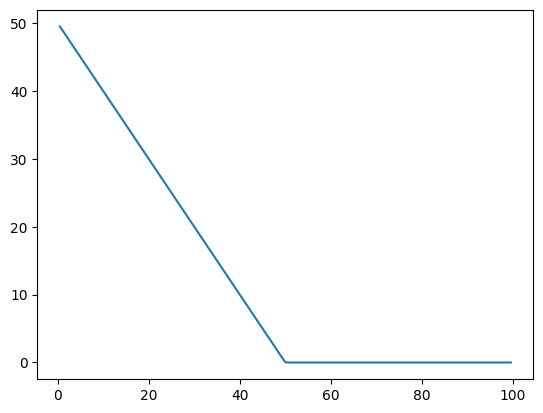

{'asset': 50.5, 'time': 0.0001, 'option': 0.0}
{'asset': 50.0, 'time': 0.0001, 'option': 0.03975000000000001}
{'asset': 49.5, 'time': 0.0001, 'option': 0.4995}
[{'asset': 0.0, 'time': 0.0001, 'option': 49.999500000000005}, {'asset': 0.5, 'time': 0.0001, 'option': 49.4995}, {'asset': 1.0, 'time': 0.0001, 'option': 48.9995}, {'asset': 1.5, 'time': 0.0001, 'option': 48.4995}, {'asset': 2.0, 'time': 0.0001, 'option': 47.9995}, {'asset': 2.5, 'time': 0.0001, 'option': 47.499500000000005}, {'asset': 3.0, 'time': 0.0001, 'option': 46.999500000000005}, {'asset': 3.5, 'time': 0.0001, 'option': 46.4995}, {'asset': 4.0, 'time': 0.0001, 'option': 45.9995}, {'asset': 4.5, 'time': 0.0001, 'option': 45.4995}, {'asset': 5.0, 'time': 0.0001, 'option': 44.9995}, {'asset': 5.5, 'time': 0.0001, 'option': 44.499500000000005}, {'asset': 6.0, 'time': 0.0001, 'option': 43.999500000000005}, {'asset': 6.5, 'time': 0.0001, 'option': 43.4995}, {'asset': 7.0, 'time': 0.0001, 'option': 42.9995}, {'asset': 7.5, 'tim

In [89]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info1[1][i+1]['asset'])
    option_price.append(info1[1][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info1[1][101])
print(info1[1][100])
print(info1[1][99])
print(info1[1])

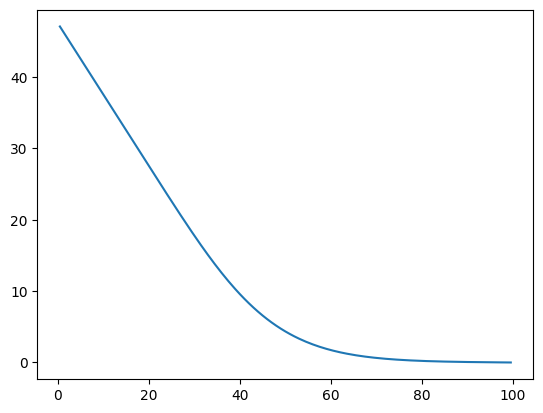

{'asset': 5.0, 'time': 0.5, 'option': 42.56145933458922}
[{'asset': 0.0, 'time': 0.5, 'option': 47.56145933460081}, {'asset': 0.5, 'time': 0.5, 'option': 47.06145933459696}, {'asset': 1.0, 'time': 0.5, 'option': 46.56145933458737}, {'asset': 1.5, 'time': 0.5, 'option': 46.06145933459243}, {'asset': 2.0, 'time': 0.5, 'option': 45.56145933459185}, {'asset': 2.5, 'time': 0.5, 'option': 45.06145933458991}, {'asset': 3.0, 'time': 0.5, 'option': 44.561459334593614}, {'asset': 3.5, 'time': 0.5, 'option': 44.06145933459454}, {'asset': 4.0, 'time': 0.5, 'option': 43.561459334592406}, {'asset': 4.5, 'time': 0.5, 'option': 43.06145933458954}, {'asset': 5.0, 'time': 0.5, 'option': 42.56145933458922}, {'asset': 5.5, 'time': 0.5, 'option': 42.061459334588754}, {'asset': 6.0, 'time': 0.5, 'option': 41.56145933458869}, {'asset': 6.5, 'time': 0.5, 'option': 41.06145933459145}, {'asset': 7.0, 'time': 0.5, 'option': 40.561459334602624}, {'asset': 7.5, 'time': 0.5, 'option': 40.06145933465005}, {'asset': 

In [90]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info1[5000][i+1]['asset'])
    option_price.append(info1[5000][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info1[5000][10])
print(info1[5000])

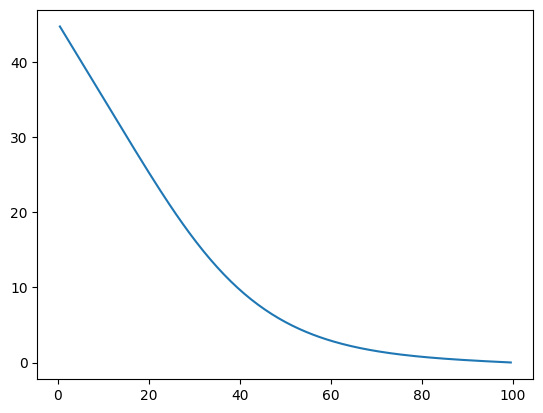

{'asset': 5.0, 'time': 0.9999, 'option': 40.24230073286598}
[{'asset': 0.0, 'time': 0.9999, 'option': 45.24230070374481}, {'asset': 0.5, 'time': 0.9999, 'option': 44.74230070373668}, {'asset': 1.0, 'time': 0.9999, 'option': 44.242300703720645}, {'asset': 1.5, 'time': 0.9999, 'option': 43.7423007037273}, {'asset': 2.0, 'time': 0.9999, 'option': 43.24230070372727}, {'asset': 2.5, 'time': 0.9999, 'option': 42.74230070372753}, {'asset': 3.0, 'time': 0.9999, 'option': 42.24230070375327}, {'asset': 3.5, 'time': 0.9999, 'option': 41.742300703932706}, {'asset': 4.0, 'time': 0.9999, 'option': 41.24230070504221}, {'asset': 4.5, 'time': 0.9999, 'option': 40.74230071053044}, {'asset': 5.0, 'time': 0.9999, 'option': 40.24230073286598}, {'asset': 5.5, 'time': 0.9999, 'option': 39.74230081006877}, {'asset': 6.0, 'time': 0.9999, 'option': 39.2423010426287}, {'asset': 6.5, 'time': 0.9999, 'option': 38.74230166590997}, {'asset': 7.0, 'time': 0.9999, 'option': 38.24230317751388}, {'asset': 7.5, 'time': 0

In [91]:
asset_price = []
option_price = []
for i in range(199):
    asset_price.append(info1[9999][i+1]['asset'])
    option_price.append(info1[9999][i+1]['option'])
    pass

plt.plot(asset_price, option_price)
plt.show()

print(info1[9999][10])
print(info1[9999])